## This lab is done by :
## Hiba JOUINI
## Sofiene LAHOUAR

In [ ]:
!pip install --upgrade pandas

- This workshop should be done groups of 2 as much as possible
- The report should be a pdf export of this notebook (no `.pynb` or `.html`)

# Content Based Recommendantion

In [ ]:
from IPython.core.display import HTML
import matplotlib.pyplot as plt
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

plt.rcParams["figure.figsize"] = (20, 10)

<div>
<img src="https://miro.medium.com/max/2400/1*BME1JjIlBEAI9BV5pOO5Mg.png" width="300"/>
</div>

## The data

The data comes from imdb. It contains movie titles `title`, associated with their description, cast and director's name, all in a single column called `combined`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import pandas as pd
with open('/content/drive/MyDrive/data/movies_db.pkl','rb') as f:
    movie_database = pd.DataFrame(pickle.load(f))[['title', 'combined']]

In [ ]:
movie_database.head()

,title,combined
0,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,Spectre,a cryptic message from bond’s past sends him o...
3,The Dark Knight Rises,following the death of district attorney harve...
4,John Carter,"john carter is a war-weary, former military ca..."


In [ ]:
print("Title\n\t{}".format(movie_database.iloc[0]['title']))
print("Description\n\t{}".format(movie_database.iloc[0]['combined']))

Title
	Avatar
Description
	in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. samworthington zoesaldana sigourneyweaver jamescameron action adventure fantasy sciencefiction


## Data preparation

##### Question 1
Use the `TfidfVectorizer` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) class to create a matrix `matrix` (vector of vectors) where each vector is the bag of word representation of the movie's description with the TfIdf weights. 

##### Solution

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
imdb_vectorizer = TfidfVectorizer(
                                  #max_df=0.8, 
                                  max_features=200000,
                                  min_df=0.001, 
                                  stop_words='english',
                                  ngram_range=(1,3))
X = imdb_vectorizer.fit_transform(movie_database['combined'])

In [ ]:
X.shape

(5999, 6452)

## Recommendation

##### Question 2
Create a function `content_based_recommender` which takes a movie title and returns the five closest movies using the distance between the previously computed vectors.

##### Solution

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def content_based_recommender(movie_title):
  
  number_of_similar_movies = 10

  similarity_matrix = cosine_similarity(X)

  title_to_index = movie_database[movie_database.title == movie_title].index.values[0]
  
  similar_movies = list(enumerate(similarity_matrix[title_to_index]))
  
  sorted_similar_movies = sorted(similar_movies,key=lambda tup: tup[1],reverse=True)[1:]

  for i in range(number_of_similar_movies):
    title = movie_database.loc[sorted_similar_movies[i][0]]['title']
    print(title)
  
  return

In [ ]:
# Testing the recommender engine
# Depending on your distance metric you can have different results
content_based_recommender('Man of Steel')

Batman v Superman: Dawn of Justice
Zack Snyder's Justice League
Dragonball Evolution
X-Men: Days of Future Past
Beastmaster 2: Through the Portal of Time
Superman II
Avatar
Jumper
Mortal Kombat
Shazam!


##### Question 3
In a production setting (real time answers, lots of users etc.):
- What are the advantages/drawbacks of this approach ?
- Which solution can we use to reduce these drawbacks ?

##### Answer


In a production setting, The advantages of this apporach are the depandency from the number of users (meaning that scaling the same algorithm for a lot of users would be easy to optimize). 

Howerever, for the drawbacks, this approach doesn't take into consideration new users who never watched a movie because it only depends on the movies you "already" watched or for old users, it can reach the point where this approach doesn't give them any new "interesting" recommandations. Also, adding new movies will require us to retrain the TF-IDF representation which can affect the results of our prediction the more we add new movies. 

Solutions: We can use the demographic information and other information from cookies to give new users recommendations based on this information. And, To mitigate the effects of TF-IDF representation (while adding new movies), we can use another type of representation of the movies with more advanced embedding techniques.

# Collaborative Filtering

<div>
<img src="https://miro.medium.com/max/2400/1*x8gTiprhLs7zflmEn1UjAQ.png" width="400"/>
</div>


## The data

The data comes from the [Book Recommendation Dataset](https://www.kaggle.com/arashnic/book-recommendation-dataset?select=Ratings.csv).

In [ ]:
import pandas as pd

read_params = {"sep":';', "on_bad_lines":'skip', "encoding":"latin-1", "compression": "gzip", "low_memory":False}
rating = pd.read_csv('/content/drive/MyDrive/data//BX-Book-Ratings.csv.gz', **read_params)
user = pd.read_csv('/content/drive/MyDrive/data/BX-Users.csv.gz', **read_params)
book = pd.read_csv('/content/drive/MyDrive/data/BX-Books.csv.gz', **read_params)

book['Book-ID'] = book.index

cols = ['Year-Of-Publication', 'Publisher', 'Book-Author', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
book_rating = pd.merge(rating, book, on='ISBN').drop(cols, axis=1)

In [ ]:
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Book-ID
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,1
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,2
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,3
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,4


---

##### Be careful, some books are published by multiple publisher. Let's say these are different books.

In [ ]:
book[book['Book-Title'] == "Skipping Christmas"]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Book-ID
758,0385505833,Skipping Christmas,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/0385505833.0...,http://images.amazon.com/images/P/0385505833.0...,http://images.amazon.com/images/P/0385505833.0...,758
1451,0385508417,Skipping Christmas,JOHN GRISHAM,2002,Doubleday,http://images.amazon.com/images/P/0385508417.0...,http://images.amazon.com/images/P/0385508417.0...,http://images.amazon.com/images/P/0385508417.0...,1451
46560,0553712837,Skipping Christmas,John Grisham,2001,Bantam Books-Audio,http://images.amazon.com/images/P/0553712837.0...,http://images.amazon.com/images/P/0553712837.0...,http://images.amazon.com/images/P/0553712837.0...,46560
51157,0375431624,Skipping Christmas,JOHN GRISHAM,2001,Random House Large Print,http://images.amazon.com/images/P/0375431624.0...,http://images.amazon.com/images/P/0375431624.0...,http://images.amazon.com/images/P/0375431624.0...,51157
79978,0739301985,Skipping Christmas,JOHN GRISHAM,2002,Random House Audio,http://images.amazon.com/images/P/0739301985.0...,http://images.amazon.com/images/P/0739301985.0...,http://images.amazon.com/images/P/0739301985.0...,79978
266661,0739420712,Skipping Christmas,John Grisham,2001,Doubleday,http://images.amazon.com/images/P/0739420712.0...,http://images.amazon.com/images/P/0739420712.0...,http://images.amazon.com/images/P/0739420712.0...,266661


In [ ]:
book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-ID
0,276725,034545104X,0,Flesh Tones: A Novel,2966
1,2313,034545104X,5,Flesh Tones: A Novel,2966
2,6543,034545104X,0,Flesh Tones: A Novel,2966
3,8680,034545104X,5,Flesh Tones: A Novel,2966
4,10314,034545104X,9,Flesh Tones: A Novel,2966


## Data Preparation

##### Question 1
 - Add a column `RatingCount_book` to `book_rating` containing the count of ratings of the corresponding book. The new dataframe will be called `user_rating`
 - Filter out books where the number of rating is below `30`
 
|    |   Book-ID |   RatingCount_book |   User-ID |       ISBN |   Book-Rating | Book-Title             |
|---:|----------:|-------------------:|----------:|-----------:|--------------:|:-----------------------|
|  0 |         5 |                 33 |         8 | 0399135782 |             0 | The Kitchen God's Wife |
|  1 |         5 |                 33 |     11676 | 0399135782 |             9 | The Kitchen God's Wife |
|  2 |         5 |                 33 |     29526 | 0399135782 |             9 | The Kitchen God's Wife |
|  3 |         5 |                 33 |     36836 | 0399135782 |             0 | The Kitchen God's Wife |
|  4 |         5 |                 33 |     46398 | 0399135782 |             9 | The Kitchen God's Wife |


###### Solution

In [ ]:
RatingCount_book = book_rating.groupby('ISBN')['Book-Rating'].count().reset_index()
user_rating = book_rating.merge(RatingCount_book, on='ISBN')
user_rating = user_rating.rename(columns={'Book-Rating_x':'Book_Rating','Book-Rating_y':'RatingCount_book'})

In [ ]:
user_rating = user_rating[user_rating['RatingCount_book']>=30]

In [ ]:
user_rating

,User-ID,ISBN,Book_Rating,Book-Title,Book-ID,RatingCount_book
0,276725,034545104X,0,Flesh Tones: A Novel,2966,60
1,2313,034545104X,5,Flesh Tones: A Novel,2966,60
2,6543,034545104X,0,Flesh Tones: A Novel,2966,60
3,8680,034545104X,5,Flesh Tones: A Novel,2966,60
4,10314,034545104X,9,Flesh Tones: A Novel,2966,60
...,...,...,...,...,...,...
794066,253226,0671737635,0,Something Wonderful,73762,34
794067,258185,0671737635,7,Something Wonderful,73762,34
794068,261768,0671737635,0,Something Wonderful,73762,34
794069,264031,0671737635,7,Something Wonderful,73762,34


##### Question 2
 - Add a column `RatingCount_user` to `user_rating` containing the count of ratings made by the user. The new dataframe will be called `final_df`
 - Filter out users where the number of rating is below `20`

 
|    |   Book-ID |   RatingCount_book |   User-ID |       ISBN |   Book-Rating | Book-Title                                                    |   RatingCount_user |
|---:|----------:|-------------------:|----------:|-----------:|--------------:|:--------------------------------------------------------------|-------------------:|
|  0 |         5 |                 33 |     11676 | 0399135782 |             9 | The Kitchen God's Wife                                        |               2495 |
|  1 |        18 |                422 |     11676 | 0440234743 |             9 | The Testament                                                 |               2495 |
|  2 |        19 |                180 |     11676 | 0452264464 |             8 | Beloved (Plume Contemporary Fiction)                          |               2495 |
|  3 |        21 |                 37 |     11676 | 1841721522 |            10 | New Vegetarian: Bold and Beautiful Recipes for Every Occasion |               2495 |
|  4 |        26 |               2502 |     11676 | 0971880107 |             6 | Wild Animus                                                   |               2495 |

##### Solution

In [ ]:
RatingCount_user =  user_rating['User-ID'].value_counts().reset_index()
RatingCount_user = RatingCount_user.rename(columns={'index':'User-ID','User-ID':'RatingCount_user'})
final_df = user_rating.merge(RatingCount_user,on='User-ID')

In [ ]:
final_df = final_df[final_df['RatingCount_user']>=20]

##### Question 3
Normalize the `Book-Rating` column using `MinMaxScaler` of `sklearn` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) and put the value in the column `Book-Rating-Scaled`

##### Solution

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_df['Book_Rating_Scaled'] = scaler.fit_transform(final_df['Book_Rating'].values.reshape(-1,1))

In [ ]:
final_df

,User-ID,ISBN,Book_Rating,Book-Title,Book-ID,RatingCount_book,RatingCount_user,Book_Rating_Scaled
13,6543,034545104X,0,Flesh Tones: A Novel,2966,60,146,0.0
14,6543,0316666343,0,The Lovely Bones: A Novel,408,1295,146,0.0
15,6543,0385504209,0,The Da Vinci Code,748,883,146,0.0
16,6543,0971880107,0,Wild Animus,26,2502,146,0.0
17,6543,0312966970,0,Four To Score (A Stephanie Plum Novel),3120,225,146,0.0
...,...,...,...,...,...,...,...,...
284176,107865,0440236991,9,Leap of Faith,31959,59,21,0.9
284177,107865,0446359637,0,Breath of Scandal,31904,36,21,0.0
284178,107865,0553294903,9,Divine Evil,31920,49,21,0.9
284179,107865,1551666510,10,The Harbor,36956,37,21,1.0


---

In [ ]:
# For later usage
# convert userID to continuous sequence of ID
codes_user, uniques_user = pd.factorize(final_df['User-ID'], sort=True)
final_df['User-ID-Continuous'] = codes_user

# convert bookID to continuous sequence of ID
codes_book, uniques_book = pd.factorize(final_df['Book-ID'], sort=True)
final_df['Book-ID-Continuous'] = codes_book

In [ ]:
# Split the dataset in train/validation
split = pd.np.random.rand(len(final_df)) < 0.8
train = final_df[split]
valid = final_df[~split]
print(train.shape , valid.shape)

(154734, 10) (38741, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


## Matrix Factorization

<div>
<img src="https://miro.medium.com/max/2000/1*WrOoSr49lQs43auSsLlLdg.png" width="800"/>
</div>

### Training

In [ ]:
import tensorflow as tf 
from tensorflow import keras

# Hyperparameters
DIM_LATENT = 100
EPOCHS = 1000
BATCH_SIZE = 32
INITIAL_LR = 10**-4

NB_USER = final_df.nunique()["User-ID-Continuous"]
NB_BOOK = final_df.nunique()['Book-ID-Continuous']

# Inputs
user_input = keras.layers.Input(shape=(1,), name='user_input', dtype='int64')
book_input = keras.layers.Input(shape=(1,), name='book_input', dtype='int64')

# Bias
user_bias = keras.layers.Embedding(NB_USER, 1)(user_input)
book_bias = keras.layers.Embedding(NB_BOOK, 1)(book_input)

# Embbeddings
user_embedding=keras.layers.Embedding(NB_USER,
                                      DIM_LATENT,
                                      name='user_embedding',
                                      embeddings_initializer="he_normal",
                                      embeddings_regularizer=keras.regularizers.l2(1e-6),
                                     )(user_input)

book_embedding=keras.layers.Embedding(NB_BOOK,
                                     DIM_LATENT,
                                     name='book_embedding',
                                     embeddings_initializer="he_normal",
                                     embeddings_regularizer=keras.regularizers.l2(1e-6),
                                    )(book_input)

# Flattening 
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
book_vec = keras.layers.Flatten(name='FlattenBooks')(book_embedding)

# Dot product between the two matrixes
dot_user_book = tf.tensordot(user_vec, book_vec, 2)

# Add all the components (including bias)
x = dot_user_book + user_bias + book_bias

# The sigmoid activation forces scores to be in [0, 1]
output = tf.nn.sigmoid(x)

mf_model = keras.models.Model([user_input, book_input], output)

mf_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LR)
)

# Earl stopping in order to stop training when overfitting begins. 
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Fit the model 
history = mf_model.fit(
    [train['User-ID-Continuous'],train['Book-ID-Continuous']],
    train['Book_Rating_Scaled'],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([valid['User-ID-Continuous'],
                      valid['Book-ID-Continuous']],
                      valid['Book_Rating_Scaled']),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/1000
4836/4836 [==============================] - 22s 4ms/step - loss: 0.6792 - val_loss: 0.6553
Epoch 2/1000
4836/4836 [==============================] - 19s 4ms/step - loss: 0.5758 - val_loss: 0.5369
Epoch 3/1000
4836/4836 [==============================] - 19s 4ms/step - loss: 0.5304 - val_loss: 0.5243
Epoch 4/1000
4836/4836 [==============================] - 19s 4ms/step - loss: 0.5241 - val_loss: 0.5159
Epoch 5/1000
4836/4836 [==============================] - 19s 4ms/step - loss: 0.5188 - val_loss: 0.5095
Epoch 6/1000
4836/4836 [==============================] - 19s 4ms/step - loss: 0.5138 - val_loss: 0.5050
Epoch 7/1000
4836/4836 [==============================] - 19s 4ms/step - loss: 0.5090 - val_loss: 0.5012
Epoch 8/1000
4836/4836 [==============================] - 19s 4ms/step - loss: 0.5051 - val_loss: 0.4981
Epoch 9/1000
4836/4836 [==============================] - 19s 4ms/step - loss: 0.5011 - val_loss: 0.4969
Epoch 10/1000
4836/4836 [==============================

In [ ]:
import matplotlib.pyplot as plt

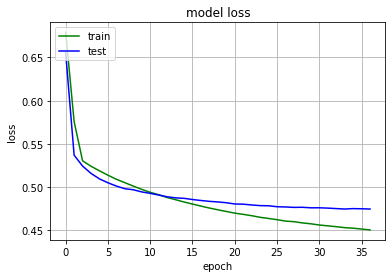

In [ ]:
# Plot learning curve
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

### Prediction

##### Question 1
Write a method called `mf_recommender` which
 - takes a user `U` using its continuous index (from 0 to `NB_USER`)
 - finds the 10 closest users to `U`
 - returns the best book unread by `U` and rated by more than 3 of these 10 closest users

**Hint**
To get the users embeddings
```python
user_emb_layer = model.get_layer('user_embedding')
user_emb_weight = user_emb_layer.get_weights()[0]
```

##### Solution

In [ ]:
user_emb_layer = mf_model.get_layer('user_embedding')
user_emb_weight = user_emb_layer.get_weights()[0]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances,manhattan_distances
import numpy as np

In [ ]:
def mf_recommender(user_id,num_recommendations=1):

  target_user = user_emb_weight[user_id]
  
  distances = cosine_similarity(X=user_emb_weight,Y=target_user.reshape(1,user_emb_weight.shape[1]))
  
  sorted_distances = sorted([(i,distances[i][0]) for i in range(user_emb_weight.shape[0])],key=lambda tup: tup[1],reverse=True)
  
  closest_10_users = [dist[0] for dist in sorted_distances[1:11]]
  
  closest_10_users_df = final_df[final_df['User-ID-Continuous'].isin(closest_10_users)]

  target_user_books = final_df[final_df['User-ID-Continuous'] == user_id]['Book-Title'].values

  closest_10_users_df = closest_10_users_df[~closest_10_users_df['Book-Title'].isin(target_user_books)]
  
  books_read_by_users = closest_10_users_df.groupby('Book-Title').agg({'User-ID':np.count_nonzero,'Book_Rating':np.mean})
  
  best_book = books_read_by_users[books_read_by_users['User-ID']>=3].nlargest(num_recommendations,'Book_Rating')
  
  return best_book.reset_index().rename(columns={'User-ID':'count','Book_Rating':'mean'})

In [ ]:
mf_recommender(0)

,Book-Title,count,mean
0,Bridget Jones's Diary,4,3.75


##### Question 2
Write a method `mf_book_recommender` which takes a book name and returns the 5 closest book names. If multiple pushishers published the same book (the title is the same), take the most rated book.

##### Solution

In [ ]:
book_emb_layer = mf_model.get_layer('book_embedding')
book_emb_weight = book_emb_layer.get_weights()[0]

In [ ]:
def mf_book_recommender(title):

  title_to_index = final_df[final_df['Book-Title']==title].nlargest(1,'RatingCount_user')['Book-ID-Continuous'].values[0]
  
  book_emb = book_emb_weight[title_to_index]
  
  distances = cosine_similarity(X=book_emb_weight, Y=book_emb.reshape(1, book_emb_weight.shape[1]))
  
  sorted_distances = sorted([(i, distances[i][0]) for i in range(book_emb_weight.shape[0])],
                              key=lambda tup: tup[1],reverse=True)
  
  top_5_books = sorted_distances[1:6]

  for idx,_ in top_5_books:
    print(final_df[final_df['Book-ID-Continuous']==idx]['Book-Title'].values[0])

  return

In [ ]:
mf_book_recommender("1984")

Pastime
Sphere
Wayside School Gets a Little Stranger (Wayside School)
Earth
A Prayer for Owen Meany


In [ ]:
mf_book_recommender('Harry Potter and the Chamber of Secrets (Book 2)')

Harry Potter and the Goblet of Fire (Book 4)
Midnight In the Garden of Good and Evil
Harry Potter and the Order of the Phoenix (Book 5)
Bitter Sweet
Christmas Box (Christmas Box Trilogy)


##### Question 3
In a production setting (real time answers, lots of users etc.):
- What are the advantages/drawbacks of this approach ?
- Which solution can we use to reduce these drawbacks ?

##### Answer

For this method, the advantages of using collobrative filtering consist of using embedding layers which are automatically learned. Also, this apporach can help existing users get new "relevent" recommendations that might be interesting for them.

But, for the drawbacks, if we have a new book which is not rated yet, we can not give any recommendations to someone about this book. The same thing apply for a new user which we described in the first part.

Solutions : We can combine this apporach with the first one in the case of a new book that hasn't been rated yet. As for new users, we can apply the same solution mentioned in the first part which is the usage of demographic information. 


# Deep Neural Network Based Recommendation Systems

![](https://miro.medium.com/max/700/1*sTBtqrsQzTKlZ8hSU7I6FQ.png)

## The data

The train data are orders from **2019-08-04**, and the test data are orders from **2019-08-05**

##### Lines

The data is contructed as follow:

- We collect every order of one day
- For each order we collect features of the user, the context and the related sales
- We pick a random sales which did not generate an order for the same user at the same time and compute the same features

We describe these two sales as positive item for the first one and negative item for the second one.

##### Columns

Here the features are anonymize and scaled. They describe different things such as:
 - The sales: the brand, the sector, the popularity of the sale at the order time,  etc.
 - The user: gender, age etc.
 - The past sales that the user viewed / bought from

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/2019-08-04_anon.csv.gz', compression="gzip", index_col=0)
X.shape

(98430, 354)

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,label
0,0.004651,0.000838,0.000918,0.011108,0.200549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.006173,0.200000,0.001812,0.150000,0.002144,0.150000,0.024321,0.717033,0.011494,0.200000,0.002591,0.150000,0.003188,0.150000,0.030599,0.717033,0.090909,0.200000,0.029126,0.150000,0.032258,0.150000,0.030599,0.717033,0.000000,0.000000,0.000000,...,0.032927,0.118435,0.034467,0.115075,0.019608,0.039459,0.0,0.000761,0.061674,0.715068,0.061674,0.715068,0.000000,1.00000,0.061674,0.715068,0.000496,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.003820,0.000000,-1.000000,0.359694,-1.000000,0.498907,0.666667,0
1,0.007442,0.000503,0.000551,0.011749,0.582418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.012346,0.250000,0.001812,0.250000,0.002144,0.250000,0.029151,0.719780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.004274,0.000613,0.000710,...,0.005357,0.015723,0.003968,0.009292,0.008000,0.004109,0.0,0.000640,0.000000,1.000000,0.230366,0.104110,0.000000,1.00000,0.382199,0.104110,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.006875,0.000000,-1.000000,0.085641,-1.000000,0.645773,0.333333,1
2,0.006512,0.000335,0.000275,0.040644,0.085165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.006173,0.142857,0.000604,0.125000,0.000715,0.166667,0.009038,0.085165,0.011494,0.142857,0.000864,0.125000,0.001063,0.166667,0.011371,0.085165,0.090909,0.142857,0.009709,0.125000,0.010753,0.166667,0.011371,0.085165,0.001832,0.000107,0.000118,...,0.021522,0.026639,0.018010,0.021109,0.000000,0.000000,0.0,0.006782,0.036561,0.002740,0.047925,0.002740,0.001482,0.00274,0.101285,0.002740,0.006532,0.02069,0.033333,0.165517,0.033333,0.068966,0.033333,0.068966,0.033333,0.0,0.076923,-1.0,0.440789,-1.0,0.440789,0.004264,0.009931,0.000000,-1.000000,0.159985,-1.000000,0.456268,0.666667,1
3,0.028837,0.002094,0.000596,0.047092,0.107143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.006173,0.032258,0.000604,0.020000,0.000715,0.076923,0.011962,0.788462,0.011494,0.032258,0.000864,0.020000,0.001063,0.076923,0.015050,0.788462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.002442,0.000400,0.000444,...,0.030000,0.026238,0.018792,0.016247,0.024000,0.010673,0.0,0.008089,0.000829,0.841096,0.014499,0.367123,0.000000,1.00000,0.015327,0.035616,0.004010,0.00000,1.000000,0.011236,0.433333,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.001528,0.000000,-1.000000,0.259840,-1.000000,0.259840,0.555556,0
4,0.018605,0.001969,0.002110,0.005106,0.101648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.018519,0.150000,0.006039,0.212766,0.007148,0.217391,0.002480,0.101648,0.011494,0.050000,0.001727,0.042553,0.002125,0.043478,0.004010,0.348901,0.090909,0.050000,0.019417,0.042553,0.021505,0.043478,0.004010,0.348901,0.009158,0.001627,0.001686,...,0.442771,0.327363,0.073610,0.043416,0.638889,0.493128,0.0,0.006776,0.012859,0.243836,0.011869,0.243836,0.000000,1.00000,0.136993,0.098630,0.000315,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.048128,0.004444,0.526258,0.103134,0.848816,0.848761,0.666667,1


## Data Preparation

In [ ]:
y = X.pop("label")

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=84)

In [ ]:
X_test = pd.read_csv('/content/drive/MyDrive/data/2019-08-05_anon.csv.gz', compression="gzip", index_col=0)
y_test = X_test.pop("label")

## Training

https://keras.io/guides/training_with_built_in_methods/

<div>
<img src="https://miro.medium.com/max/2400/1*zP6mLVMzxjFdK-XaOz1hjg.png" width="500"/>
</div>

### Pointwise

Like the "Ensemble Method" workshop, we have features and we want to predict a label which is the probability of generating an order. The recommendation here is a ranking problem where we want to display to the users the sales which will most likely generate an order

##### Question 1
Write a Neural Network algorithm (using Keras) which takes the train dataset and and tries to predict the `label` using all the `features` (the features are already normalized). Don't forget to use the validation dataset.

The network should have 3 layers: Input, Dense(256), Dense(128) and returns an order probability.

You can implement an early stopping mechanism using callbacks ([documentation](https://keras.io/api/callbacks/early_stopping/))

You should also display the evolution of the loss accross the epoch.

##### Solution

In [ ]:
EPOCHS = 1000
BATCH_SIZE = 32
INITIAL_LR = 10**-4 #10**-4

x = keras.layers.Input(shape=(353,), name='features')

dense_1 = keras.layers.Dense(256,activation="relu",name="layer_256")(x)

dropout_1 = keras.layers.Dropout(0.1)(dense_1)

dense_2 = keras.layers.Dense(128,activation="relu",name="layer_128")(dropout_1)

output = keras.layers.Dense(1,activation="sigmoid",name="output")(dense_2)

model = keras.Model(x,output)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LR)
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)


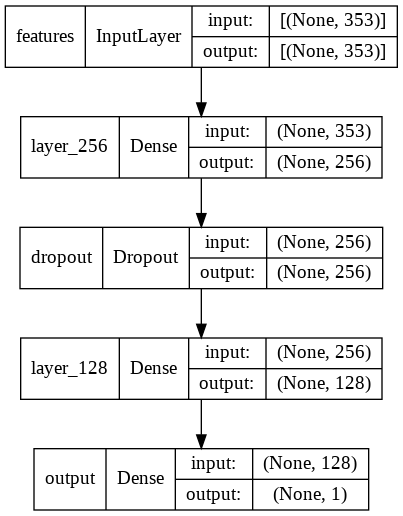

In [ ]:
# Depending on your computer's configuration these lines may not work
# It is just to illustrate what we want
dot_img_file = 'model.png'
#model = get_model()
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

If you do:
```python
history = model.fit(...)
```
you will then be able to plot the evolution of the losses

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_eval,y_eval),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/1000
2461/2461 [==============================] - 8s 3ms/step - loss: 0.4214 - val_loss: 0.3984
Epoch 2/1000
2461/2461 [==============================] - 7s 3ms/step - loss: 0.3940 - val_loss: 0.3904
Epoch 3/1000
2461/2461 [==============================] - 7s 3ms/step - loss: 0.3853 - val_loss: 0.3858
Epoch 4/1000
2461/2461 [==============================] - 7s 3ms/step - loss: 0.3793 - val_loss: 0.3808
Epoch 5/1000
2461/2461 [==============================] - 7s 3ms/step - loss: 0.3753 - val_loss: 0.3929
Epoch 6/1000
2461/2461 [==============================] - 7s 3ms/step - loss: 0.3706 - val_loss: 0.3754
Epoch 7/1000
2461/2461 [==============================] - 7s 3ms/step - loss: 0.3682 - val_loss: 0.3736
Epoch 8/1000
2461/2461 [==============================] - 7s 3ms/step - loss: 0.3654 - val_loss: 0.3716
Epoch 9/1000
2461/2461 [==============================] - 7s 3ms/step - loss: 0.3631 - val_loss: 0.3722
Epoch 10/1000
2461/2461 [==============================] - 7s 3m

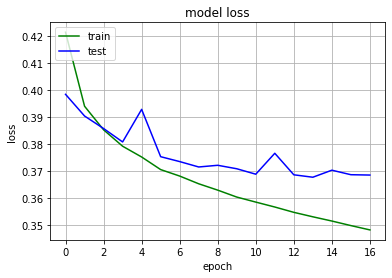

In [ ]:
# Plot learning curve
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test.values, y_test.values, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
648/648 [==============================] - 2s 3ms/step - loss: 0.3980
test loss, test acc: 0.397986501455307


In [ ]:
predictions = (model.predict(X_test.values).flatten() >= 0.5).astype(int)
proba = sum(y_test.values == predictions) / len(predictions)
print("Probability of good prediction with a threshold at 0.5: {}".format(proba))

Probability of good prediction with a threshold at 0.5: 0.8203965459018766


##### Question 2
Evaluate your algorithm on the "real" test dataset: before putting our algorithm in production, we want to evaluate its performances offline. As the main goal is to rank the sales of the homepage, we will observe all the order of the past and try to rank all the sales of the homepage at that time. Then we compute the rank of the sales which generated an order to validate our algorithm.

In the next testset the `id` correspond to all the sales displayed to a user who made an order. Only one sale will have the `label` `1`. This is the sale which generated an order.

You will have compute the mean rank of all positive examples (label=1) when scored and ranked by your algorithm's predictions.
 

##### Solution

In [ ]:
X_test = pd.read_csv('/content/drive/MyDrive/data/2020-08-05_anon.csv.gz', compression="gzip", index_col=0)
y_test = X_test.pop("label")
ids = X_test.pop("id")

In [ ]:
df=pd.concat([ids,pd.Series(model.predict(X_test).flatten()),y_test],axis=1)

In [ ]:
df = df.rename(columns={0:'prediction_score'})

In [ ]:
df = df.sort_values(by=["id","prediction_score"],ascending=False)

In [ ]:
rank = []
for id in df["id"].unique():
  rank = rank + list(range(1,len(df[df['id']==id])+1))
df['rank'] = rank

In [ ]:
df['rank'] = rank 

In [ ]:
mean_rank = df[df["label"]==1]['rank'].mean()

In [ ]:
mean_rank

3.601

##### Question 3
In a production setting (real time answers, lots of users etc.):
- What are the advantages/drawbacks of this approach ?
- Which solution can we use to reduce these drawbacks ?

##### Answer

For this apporach, This model will provide a user with specific and good recommendations, but Having a lot of users, the model will take too much time to compute the ranking of sales for one of them individually.

The solution for this problem is to parallelize tensorflow predictions and try to reduce the prediction time as much as possible.